# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [0]:
# !pip3 -qq install torch==0.4.1
# !pip3 -qq install bokeh==0.13.0
# !pip3 -qq install gensim==3.6.0
# !pip3 -qq install nltk
# !pip3 -qq install scikit-learn==0.20.2

In [0]:
!pip3 -qq install torch

In [0]:
!pip3 -qq install bokeh

In [0]:
!pip3 -qq install gensim

In [0]:
!pip3 -qq install nltk

In [0]:
!pip3 -qq install scikit-learn

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [8]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения:

In [9]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [10]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [11]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'ADJ', 'DET', 'NOUN', '.', 'PRT', 'PRON', 'X', 'VERB', 'ADV', 'CONJ', 'ADP', 'NUM'}


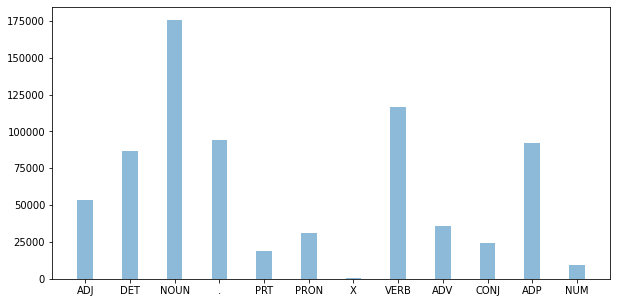

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [13]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [14]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [15]:
trigram_tagger = nltk.TrigramTagger(train_data, backoff=bigram_tagger)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 93.43%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [0]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [17]:
X_test[0], y_test[0]

([9242, 25966, 19009], [1, 3, 3])

In [0]:
def iterate_batches(data, batch_size):
    # предложения по индексам слов + тэги
    X, y = data
    # количество предложений
    n_samples = len(X)

    # список индексов
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        
        # end не должен превышать максимальный индекс
        end = min(start + batch_size, n_samples)
        
        # берем подряд сколько получилось индексов
        batch_indices = indices[start:end]
        
        # ищем самое длинное предложение в текущей пачке
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        # матрица по длине самого длинного и количеству индексов
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        # для тэгов то же самое
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        # заполняем матрицы тэгами, подгоняя длину под размер предложений
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [19]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count)
        self.out = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeds = self.embed(inputs)
        hidden, _ = self.lstm(embeds)
        out = self.out(hidden)
        return out

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [0]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

In [23]:
X_batch.shape

torch.Size([32, 4])

In [26]:
X_batch

tensor([[43741,  5624, 23112,   808],
        [14007, 36382, 22886, 39809],
        [10893, 14837, 34394, 20279],
        [  808, 28161, 19648, 35724],
        [13739, 35911, 10893, 14837],
        [14837, 37689,   880,  1053],
        [  808, 32312, 14837, 38189],
        [19142, 34856, 11922, 28113],
        [14472, 25708,  2628,  8552],
        [43617,   808,   808,  4642],
        [14837, 13012, 45146, 14837],
        [40155, 28250, 42816,  8552],
        [15023, 14837,   808, 41044],
        [15696, 42410, 27277,  3872],
        [    0, 25732, 36795,  3976],
        [    0, 38111, 14837, 19448],
        [    0, 13764,   808, 22886],
        [    0, 42816,  9923,  9146],
        [    0,   808, 42816, 25984],
        [    0, 29412, 18730, 30894],
        [    0, 42816, 11494, 10893],
        [    0, 19345, 19010, 26536],
        [    0, 15696, 42607, 15696],
        [    0,     0,  8413,     0],
        [    0,     0, 19822,     0],
        [    0,     0, 39343,     0],
        [   

In [25]:
logits.shape

torch.Size([32, 4, 13])

In [20]:
# <calc accuracy>
# учитываем только те значния, где y_batch != 0
# нужно использовать маскинг - умножение на маску из нулей и единиц,
# где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).
def acc_calc(logits, y_batch):
    mask = (y_batch != 0).float()
    preds = torch.argmax(logits, dim=-1)

    correct_cnt = ((preds == y_batch).float() * mask).sum()
    all_cnt = mask.sum()

    return correct_cnt.item(), all_cnt.item()

a, b = acc_calc(logits, y_batch)
print(a/b)

0.16304347826086957


In [21]:
def loss_calc(logits, y_batch):
    criterion = nn.CrossEntropyLoss()
    # loss на батче
    loss_list = []
    for i, sample in enumerate(logits):
      loss_list.append(criterion(sample, y_batch[i]))

    return sum(loss_list)

loss_calc(logits, y_batch)

tensor(82.1478, grad_fn=<AddBackward0>)

**Задание** Вставьте эти вычисление в функцию:

In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = loss_calc(logits, y_batch)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                cur_correct_count, cur_sum_count = acc_calc(logits, y_batch)

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [0]:
device = torch.device("cuda:0")

In [24]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=1,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 1] Train: Loss = 19.51314, Accuracy = 71.61%: 100%|██████████| 572/572 [00:20<00:00, 27.37it/s]
[1 / 1]   Val: Loss = 9.32413, Accuracy = 85.17%: 100%|██████████| 13/13 [00:00<00:00, 33.01it/s]


In [25]:
def evaluate_model(model, data, batch_size=64):
    model.eval() # Evaluation mode

    correct_count = 0
    sum_count = 0

    for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
        X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
        
        X_batch_gpu = X_batch.to(device)
        y_batch_gpu = y_batch.to(device)
        
        logits = model(X_batch_gpu)

        cur_correct_count, cur_sum_count = acc_calc(logits, y_batch_gpu)

        correct_count += cur_correct_count
        sum_count += cur_sum_count


    return correct_count/sum_count

data_train = (X_test, y_test)
evaluate_model(model, data_train)

0.854194423501303

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [26]:
test_data = (X_test, y_test)
test_batch_size = 512
do_epoch(model, criterion, test_data, test_batch_size, None, 'Test:')

Test: Loss = 9.26409, Accuracy = 85.42%: 100%|██████████| 28/28 [00:00<00:00, 33.19it/s]


(9.264092479433332, 0.854194423501303)

### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [0]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, word_emb_dim)
        # bidirectional=True
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        # удваивается выход сети
        self.out = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        embeds = self.embed(inputs)
        hidden, _ = self.lstm(embeds)
        out = self.out(hidden)
        return out

In [29]:
model = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=1,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 1] Train: Loss = 15.64469, Accuracy = 76.72%: 100%|██████████| 572/572 [00:21<00:00, 26.20it/s]
[1 / 1]   Val: Loss = 6.67814, Accuracy = 89.74%: 100%|██████████| 13/13 [00:00<00:00, 29.24it/s]


In [30]:
data_test = (X_test, y_test)
evaluate_model(model, data_test)

0.8988566766160933

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [31]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Построим подматрицу для слов из нашей тренировочной выборки:

In [59]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


In [66]:
embeddings.shape

(45441, 100)

**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [0]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self.embed = nn.Embedding.from_pretrained(embeddings)
        # bidirectional=True
        self.lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        # удваивается выход сети
        self.out = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        embeds = self.embed(inputs)
        hidden, _ = self.lstm(embeds)
        out = self.out(hidden)
        return out

In [61]:
embeddings_tensor = torch.from_numpy(embeddings)
embeddings_tensor = embeddings_tensor.float().to(device)

model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings_tensor,
    tagset_size=len(tag2ind)
)

model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=1,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 1] Train: Loss = 19.75574, Accuracy = 78.96%: 100%|██████████| 572/572 [00:18<00:00, 31.21it/s]
[1 / 1]   Val: Loss = 6.31756, Accuracy = 91.10%: 100%|██████████| 13/13 [00:00<00:00, 37.08it/s]


**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [62]:
data_test = (X_test, y_test)
evaluate_model(model, data_test)

0.9128340717942363